In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

## The quantum harmonic oscillator: brief remarks

The Hamiltonian of the quantum harmonic oscillator in the energy eigenbasis is defined as
$$
\hat{H} = \omega \hat{a}^\dagger \hat{a} \, ,
$$
where $\omega$ is the resonance frequency and $\hat{a}$ is the bosonic annihilation operator.

In [2]:
N = 120 # Hilbert space cutoff
w = 1 # Resonance frequency of the harmonic oscillator

a = destroy(N)

# The Hamiltonian
H = w * a.dag() * a

H

Quantum object: dims=[[120], [120]], shape=(120, 120), type='oper', dtype=Dia, isherm=True
Qobj data =
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   1.   0. ...   0.   0.   0.]
 [  0.   0.   2. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 117.   0.   0.]
 [  0.   0.   0. ...   0. 118.   0.]
 [  0.   0.   0. ...   0.   0. 119.]]


### Passing in the position basis

We can also express the system in the position basis (eigenstates of the position operator $\hat{x}$), rather than the energy basis. In this way, the position and momentum operators are expressed as ($\hbar = 1$):

$$
\hat{x} = \frac{1}{\sqrt{2 m \omega}} \left( \hat{a} + \hat{a}^\dagger \right)
$$
$$
\hat{p} = i \sqrt{\frac{m \omega}{2}} \left( \hat{a}^\dagger - \hat{a} \right) \, .
$$

We first check that
$$
\left[ \hat{x}, \hat{p} \right] = i
$$

In [3]:
m = 0.5

x = (a + a.dag()) / np.sqrt(2 * m * w)
y = - 1j * (a - a.dag()) * np.sqrt(m * w / 2)

commutator(x, y)

Quantum object: dims=[[120], [120]], shape=(120, 120), type='oper', dtype=Dia, isherm=False
Qobj data =
[[0.  +1.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +1.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +1.j ... 0.  +0.j 0.  +0.j 0.  +0.j]
 ...
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.  +1.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +1.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j ... 0.  +0.j 0.  +0.j 0.-119.j]]

We now numerically diagonalize the position operator $\hat{x}$, such that $\hat{U}^\dagger \hat{x} \hat{U}$ is diagonal. Then we plot the eigenstates of the quantum harmonic oscillator in the new basis, obtained with
$$
\vert \phi_n (x) \rangle = \hat{U}^\dagger \vert \psi_n \rangle
$$

(0.0, 5.0)

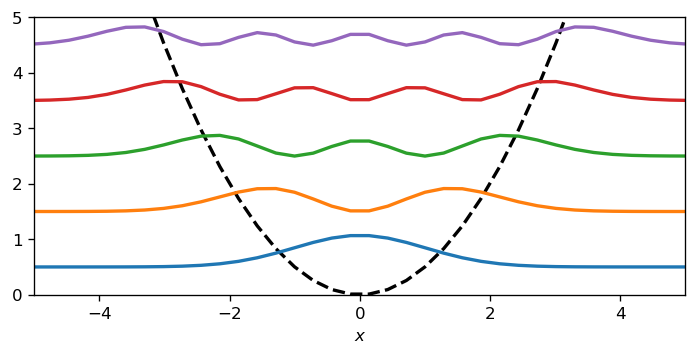

In [4]:
E, T = x.eigenstates()

U = np.zeros((N, N)).astype(np.complex128)
for i in range(N):
    U[:,i] = T[i].full().flatten()

U = Qobj(U)

xlist = ( U.dag() * x * U ).diag()
dx = xlist[1] - xlist[0]

# Harmonic potential
V = w**2 / 2 * xlist**2

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(xlist, V, color="black", ls="--", lw=2)
for i in range(5):
    factor = 5 # The purpose of this factor is to only make more visible the states
    ax.plot(xlist, factor * np.abs( (U.dag() * fock(N, i)).full() )**2 + i * w + w/2, lw=2)

ax.set_xlabel(r"$x$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 5)

## Closed Dynamics: The $\text{Schr\"{o}dinger}$ equation

In [5]:
alpha = 3 # Coherence of the initial state

# We start from a coherent state the most classic-like state
psi0 = coherent(N, alpha)

# List of the times for the time evolution
tlist = np.linspace(0, 2 * 2*np.pi/w, 100)

e_ops = [H, a + a.dag()]

sol = sesolve(H, psi0, tlist, e_ops)

### Plot the expectation values

We can access to the expectation values with the command `sol.expect[i]`, where `i` is the index of the $i$-th operator for which we want to calculate te expectation value as a function of time. 

(-6.7468247855685135, 16.0)

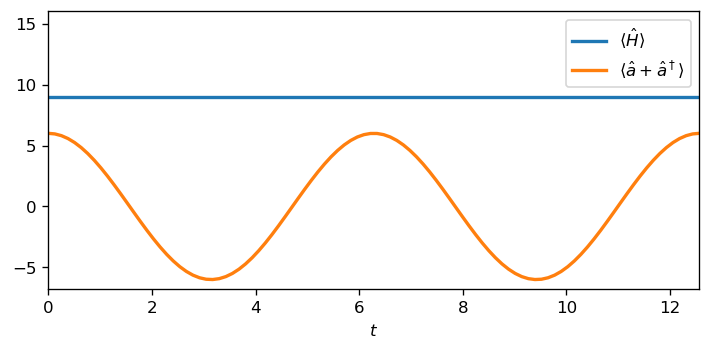

In [6]:
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 16)

### Access directly to the evolution of the state

We can also access directly to the wavefunction at each `tlist`. This can be done by simply calling `sol.states` to the solver without the `e_ops` operators.

To check this feature, let's see if after $10$ cycles we get still the initial state, by calculating the fidelity
$$
\langle \psi \left(t = 10 T\right) \vert \psi \left( t = 0 \right) \rangle
$$
where $T = \frac{2 \pi}{\omega}$.

In [7]:
sol = sesolve(H, psi0, tlist)

sol.states[0].dag() * sol.states[-1]

(0.999999999991156-6.853074431693678e-07j)

We then switch to the position eigenbasis. Thus, we need to diagonalize the position operator. This in general involves the _Laguerre_ functions, but here we limit ourselves to numerically diagonalize the position operator.

We now show the wavefunctions in the position basis at three different times: $t_0$, $t_1$ and $t_2$, with
$$
t_0 = 0 \, , \quad t_1 = \frac{\pi}{\omega} \, , \quad t_2 = \frac{2 \pi}{\omega} \, ,
$$
showing the exact periodicity of thi system.

(0.0, 120.0)

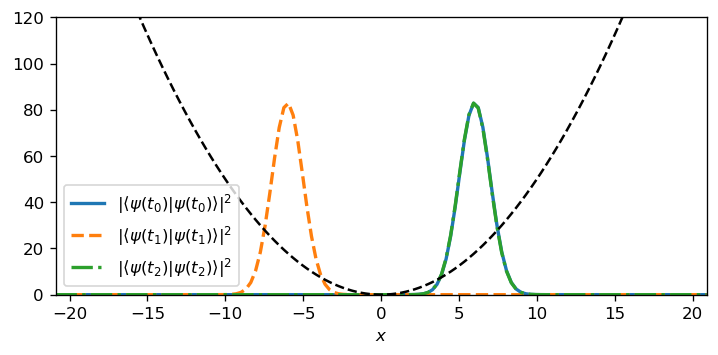

In [8]:
idx_t0 = 0
idx_t1 = np.where(tlist >= np.pi/w)[0][0]
idx_t2 = np.where(tlist >= 2*np.pi/w)[0][0]

psi0_x = U.dag() * sol.states[idx_t0]
psi1_x = U.dag() * sol.states[idx_t1]
psi2_x = U.dag() * sol.states[idx_t2]

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, label=r"$\vert \langle \psi (t_0) \vert \psi (t_0) \rangle \vert^2$", lw=2)
ax.plot(xlist, 700 * np.abs(psi1_x.full())**2, label=r"$\vert \langle \psi (t_1) \vert \psi (t_1) \rangle \vert^2$", ls="--", lw=2)
ax.plot(xlist, 700 * np.abs(psi2_x.full())**2, label=r"$\vert \langle \psi (t_2) \vert \psi (t_2) \rangle \vert^2$", ls="-.", lw=2)
ax.plot(xlist, V, color="black", ls="--")
ax.legend()
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 120)

We can also export an animation, showing more easily the time evolution of the state

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [10]:
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

line, = ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, lw=2)
ax.plot(xlist, V, color="black", ls="--")
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 120)

plt.close(fig) # Otherwise the static figure also appears

def update(frame):
    psi_t = U.dag() * sol.states[frame]
    line.set_ydata( 700 * np.abs(psi_t.full())**2 )
    return line,

fps = 25
ani = FuncAnimation(fig, update, frames=len(tlist), blit=True, interval=1000 / fps)

HTML(ani.to_html5_video())
# HTML(ani.to_jshtml())

### <span style="color:red">**Exercise!**</span>

<ins>*What happens if we start from the following superposition state?*</ins>
$$
\vert \psi (0) \rangle = \frac{1}{\sqrt{2}} \left( \vert 2 \rangle + \vert 5 \rangle \right)
$$
<ins>*Write a code that generates the animation of the wavefunction

In [11]:
# Write your code here...





In [11]:
# Solution:
psi0 = (fock(N, 2) + fock(N, 5)).unit()

# List of the times for the time evolution
tlist = np.linspace(0, 2 * 2*np.pi/w, 100)

sol = sesolve(H, psi0, tlist)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

line, = ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, lw=2)
ax.plot(xlist, V, color="black", ls="--")
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 120)

plt.close(fig) # Otherwise the static figure also appears

def update(frame):
    psi_t = U.dag() * sol.states[frame]
    line.set_ydata( 700 * np.abs(psi_t.full())**2 )
    return line,

fps = 25
ani = FuncAnimation(fig, update, frames=len(tlist), blit=True, interval=1000 / fps)

# HTML(ani.to_jshtml())
HTML(ani.to_html5_video())

## Open Dynamics: The Master Equation

In contrast to the closed case, open quantum systems interact with their environment, leading to non-unitary evolution described by the Master equation:

$$
\frac{d \hat{\rho}}{dt} = -\frac{i}{\hbar}[\hat{H}, \hat{\rho}] + \sum_k \left( \hat{L}_k \hat{\rho} \hat{L}_k^\dagger - \frac{1}{2} \{\hat{L}_k^\dagger \hat{L}_k, \hat{\rho}\} \right)
$$

Here, $\hat{\rho}$ represents the density matrix of the system, $\hat{L}_k$ are the Lindblad operators representing different dissipation processes. and $\{\hat{A}, \hat{B} \} = \hat{A} \hat{B} + \hat{B} \hat{A}$ is the anti-commutator between the operators $\hat{A}$ and $\hat{B}$.

(-5.074499442383836, 16.0)

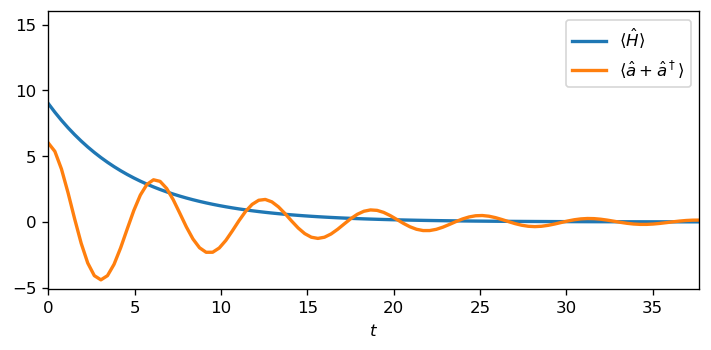

In [12]:
gamma = 0.2 # Decay rate

psi0 = coherent(N, alpha)

c_ops = [np.sqrt(gamma) * a]

tlist = np.linspace(0, 6 * 2*np.pi, 100)

sol = mesolve(H, psi0, tlist, c_ops, e_ops)




fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 16)

## Driven Dissipative Harmonic Oscillator

The driven dissipative harmonic oscillator is a foundational concept in quantum optics, illustrating how quantum systems interact with external forces and their environment. This section begins with the time-dependent Hamiltonian, transitions to a time-independent form via a unitary transformation, and delves into the significance of this transition.

### Initial Time-Dependent Hamiltonian

The Hamiltonian for a driven harmonic oscillator, subject to a time-dependent external driving force, is expressed as:

$$
\hat{H}(t) = \hbar \omega \hat{a}^\dagger \hat{a} + \left( F(t) \hat{a}^\dagger + F^*(t) \hat{a} \right)
$$

where $F(t) = Fe^{i\omega_d t}$ represents the time-dependent drive with $F$ being the drive strength and $\omega_d$ the drive frequency.

This Hamiltonian encapsulates the energy dynamics of the system under natural oscillations and external driving forces.

### Transition to a Time-independent Hamiltonian

To simplify the analysis, a transition to a rotating frame matching the drive frequency is performed through a unitary transformation $\hat{U}(t)$:

$$
\hat{U}(t) = e^{-i\omega_d \hat{a}^\dagger \hat{a} t}
$$

The time-independent Hamiltonian in the rotating frame, $\hat{H}'$, is derived using:

$$
\hat{H}' = \hat{U}^\dagger(t) \hat{H}(t) \hat{U}(t) - i\hbar \hat{U}^\dagger(t) \frac{\partial \hat{U}(t)}{\partial t}
$$

Upon substitution and simplification, the transformed Hamiltonian becomes:

$$
\hat{H}' = \hbar(\omega - \omega_d) \hat{a}^\dagger \hat{a} + (F \hat{a}^\dagger + F^* \hat{a})
$$

This Hamiltonian, now free of explicit time dependence, facilitates the application of quantum mechanical principles for the analysis of system dynamics. In particular, it includes a term for detuning between the natural frequency of the oscillator and the drive frequency, as well as the drive interaction in the rotating frame.

Notice that the dissipator term (Linblad term) in the master equation is invariant under this transformation!
You can now rewrite the master equation like:
$$
\partial_t \hat{\rho} = -i[\hat{H}', \hat{\rho}] + \gamma\left(  \hat{a} \hat{\rho} \hat{a}^{\dagger} - \frac{1}{2}\lbrace{\hat{a}^{\dagger} \hat{a}, \hat{\rho}\rbrace} \right)
$$

### Steady state
In a driven-dissipative quantum system is fundamental the concept of steady-state. The steady-state is a density matrix (so a mixed state!) $\hat{\rho}_{ss}$ for which
$$
\partial_t \hat{\rho}_{ss} = 0.
$$

In our simple example above this stae can be obtained by computing the kernel (in linear algebra meaning, i.e. the zeros) of the operator defined by 
$$
\mathcal{L}[\hat{\rho}] = -i[\hat{H}', \hat{\rho}] + \gamma\left(  \hat{a} \hat{\rho} \hat{a}^{\dagger} - \frac{1}{2}\lbrace{\hat{a}^{\dagger} \hat{a}, \hat{\rho}\rbrace} \right) 
$$
Notice that $\mathcal{L}$ is an operator-valued operator, so it takes as an input an operator and gives as output an operator. Often people call these object "super-operators" (mathematically I think it can be also called a tensor).
Anyway a useful way to deal with superoperators is to flatten them into a matrix. Under the same operatio the density matrix is flatten into a vector.
Then one can diagonalize $\mathcal{L}$ and find the steady state. Indeed there is mathematical proof that any "standard" Linblad dissipators have a single eigenvalue which is zero, always. (There are more pathological cases in which there exists multiple zeros eigenvalues, but this case are either trivial or either super complicated, so we skip them).
Finding the zero eigenvalue corresponds to find the steady state.
You do not have to bether, QuTip does it for you with the function "mesolve".





In [13]:
# System parameters
N = 30  # Number of Fock states
omc = 1.  # main frequency
gamma = 0.1  # Dissipation rate
F = 0.04  # Drive strength
omF = 1. #Drive frequency
# Operators
a = destroy(N)

H = omc * a.dag() * a

Hdriven = H - omF * a.dag() * a + F*(a+a.dag()) # Driven Hamiltonian in the rotating frame

c_ops = [np.sqrt(gamma)*a] #given jump operators (in this case only 'a')
rho_ss = steadystate(Hdriven, c_ops) #Steady state of the master equation for a given H 
rho_ss

Quantum object: dims=[[30], [30]], shape=(30, 30), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.27292424e-01+0.00000000e+00j  0.00000000e+00+4.21833939e-01j
  -2.38625311e-01+0.00000000e+00j  0.00000000e+00-1.10216310e-01j
   4.40865240e-02+0.00000000e+00j  0.00000000e+00+1.57728743e-02j
  -5.15139919e-03+0.00000000e+00j  0.00000000e+00-1.55763670e-03j
   4.40566190e-04+0.00000000e+00j  0.00000000e+00+1.17484317e-04j
  -2.97214426e-05+0.00000000e+00j  0.00000000e+00-7.16908170e-06j
   1.65562850e-06+0.00000000e+00j  0.00000000e+00+3.67350981e-07j
  -7.85429436e-08+0.00000000e+00j  0.00000000e+00-1.62237607e-08j
   3.24475213e-09+0.00000000e+00j  0.00000000e+00+6.29574389e-10j
  -1.18713685e-10+0.00000000e+00j  0.00000000e+00-2.17878298e-11j
   3.89752548e-12+0.00000000e+00j  0.00000000e+00+6.80407830e-13j
  -1.16050749e-13+0.00000000e+00j  0.00000000e+00-1.93586032e-14j
   3.16124667e-15+0.00000000e+00j  0.00000000e+00+5.05799463e-16j
  -7.93563258e-17+0.00000000e+00j  0.0000

What do we do with the steady state? Well, we can compute steady state quantities.
Think about what's happening: your harmonic oscillator represents a single electric field mode of a Fabry-Perot cavity and you are illuminating this cavity with a laser (the drive). Photons can enter and exit the cavity because of the dissipations (or losses) in the mirrors, which are non completely reflective but semi-transparent.
You keep the laser shining its light from outside on one of the mirrors, while you collect the light escaping from the other mirror. After a while the system is going to be in the steady state.

You can perform measurements on the output light of your cavity. For instance you collect this light in an interferometer and measure the $g^{(2)}(\tau)$ as a function of the time delay $\tau$ in the arms of the interferometer.

All this abstract operation can be put in a numerical framework using the theory + the truncation procedure to represent fields, operators and states as matrices and vectors (basically using QuTip).

Here below you find the normalized $g^{(2)}$.

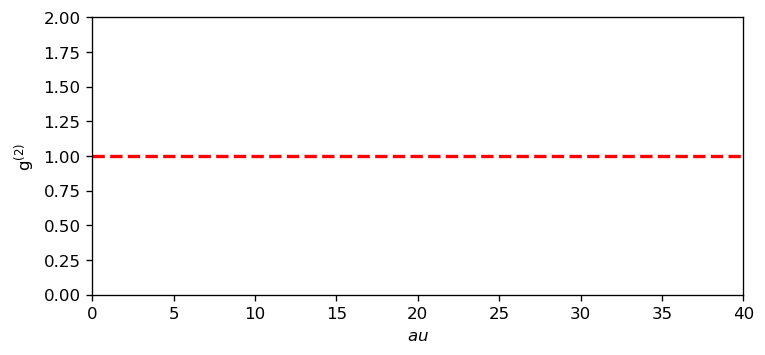

In [14]:
taus = np.linspace(0., 40., 200)
G2 = correlation_3op_1t(Hdriven, rho_ss, taus, c_ops, a.dag(), a.dag()*a, a)
avgNph = expect(a.dag()*a, rho_ss)
g2 = G2/(avgNph**2.)

# plot the spectrum
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))
ax.plot(taus, np.abs(g2), 'r--', lw=2)
ax.set_xlabel('$\tau$')
ax.set_ylabel('g$^{(2)}$')
plt.axis( [0, 40, 0, 2] )
plt.show()

### <span style="color:red">**Exercise!**</span>

<ins>*Let's consider that the environmet is a temperature $T$. It means that our cavity is sourronded by a thermal ensemble of photons, like as it is embedded inside a black-body.
If you go back on your quantum optics course (or look at Gardiner-Zoller 'quantum noise' book, or, even better to Cohen-Tannoudji 'Atom-Photon interactions' book) you find that the master equation is modified to*</ins>
$$
    \mathcal{L}[\hat{\rho}] = -i[\hat{H}', \hat{\rho}] + \gamma(1+N_{\rm th}(T))\left(  \hat{a} \hat{\rho} \hat{a}^{\dagger} - \frac{1}{2}\lbrace{\hat{a}^{\dagger} \hat{a}, \hat{\rho}\rbrace} \right) + \gamma N_{\rm th}(T)\left(  \hat{a}^{\dagger} \hat{\rho} \hat{a} - \frac{1}{2}\lbrace{\hat{a} \hat{a}^{\dagger}, \hat{\rho}\rbrace} \right) 
$$
<ins>*where $N_{\rm th}(T)= 1/( \exp[\omega/(k_b T)] - 1)$ is the Bose-Einstein distribution of the harmonic oscillator.*</ins>

<ins>*The first Linblad dissipator term is only rescaled by the factor $(1+N_{\rm th}(T))$, but the real novelty is the appearence of a new term, still in the Linblad form, scaled by $N_{\rm th}(T)$. This last term has the annihilation and creation operators swapped, and thus is not a dissipator term but rather a pumping term. It pumps thermal photons into the system. The fact that the dissipator is proportional to $(1+N_{\rm th}(T))$ and the thermal absorption is proportional to $N_{\rm th}(T)$ ensures the correct thermalization in the steady state, and it is nothing else than a fancy rewriting of the good old A,B Einstein coefficient for spontaneous emission, stimulated emission and absorption.*</ins>

<ins>*Rewrite the exercise above in the new framework.*</ins>

In [ ]:
# Write your code here...





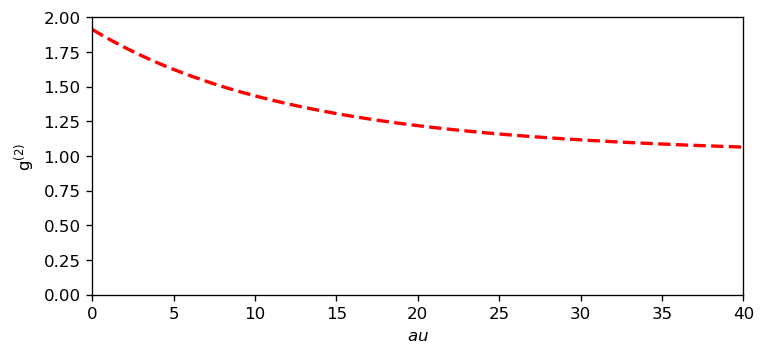

In [15]:
# Solution:

# System parameters
N = 30  # Number of Fock states
omc = 1.  # main frequency
gamma = 0.1  # Dissipation rate
F = 0.04  # Drive strength
omF = 1. #Drive frequency
# Operators
a = destroy(N)

H = omc * a.dag() * a

Hdriven = H - omF * a.dag() * a + F*(a+a.dag()) # Driven Hamiltonian of the Kerr oscillator in the rotating frame

T = 2 # I set the temperature (k_b=1 We stay in units where Bolzmann constant is 1 )

Nth = 1./( np.exp(omc/T) - 1.)

c_ops = [np.sqrt(gamma*(1. + Nth))*a, np.sqrt(gamma*Nth)*a.dag() ] #given jump operators (in this case only 'a')
rho_ss = steadystate(Hdriven, c_ops) #Steady state of the master equation for a given H 

taus = np.linspace(0., 40., 200)
G2 = correlation_3op_1t(Hdriven, rho_ss, taus, c_ops, a.dag(), a.dag()*a, a)
avgNph = expect(a.dag()*a, rho_ss)
g2 = G2/(avgNph**2.)

# plot the spectrum
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))
ax.plot(taus, np.abs(g2), 'r--', lw=2)
ax.set_xlabel('$\tau$')
ax.set_ylabel('g$^{(2)}$')
plt.axis( [0, 40, 0, 2] )
plt.show()

### Time-dependent case
Here we take a quick look to what happens if you cannot use the trick of the rotating frame. Solving for steady states is not so easy anymore and you have to deal with the full quantum time evolution.

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.26s


(0.0, 150.0)

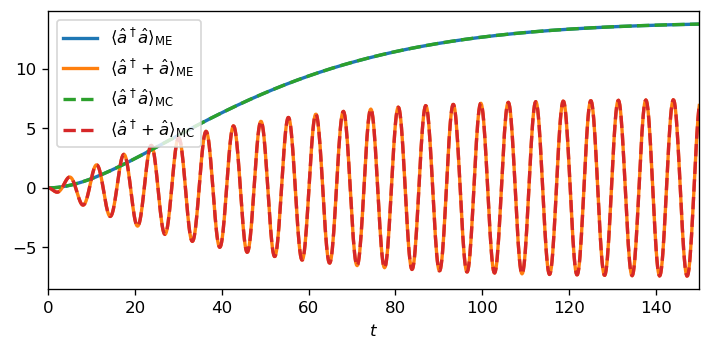

In [16]:
# System parameters
N = 50  # Number of Fock states
omega = 1  # Frequency of the oscillator
gamma = 0.05  # Dissipation rate
F = 0.1  # Drive strength
omega_d = 0.99  # Drive frequency

# Time-dependent drive function
def drive1(t, args):
    return F * np.exp(-1j * omega_d * t)

def drive2(t, args):
    return F * np.exp(1j * omega_d * t)

# Operators
a = destroy(N)
H0 = omega * a.dag() * a # Hamiltonian of the harmonic oscillator

# Time-dependent Hamiltonian
H = [H0, [a.dag(), drive1], [a, drive2]]

# Initial state
psi0 = basis(N, 0)

# Collapse operators
c_ops = [np.sqrt(gamma) * a]

# Time points
times = np.linspace(0, 150, 1000)

# Solving the dynamics with mesolve
result_me_td = mesolve(H, psi0, times, c_ops, [a.dag() * a, a.dag() + a])

# Solving the dynamics with mcsolve
result_mc_td = mcsolve(H, psi0, times, c_ops, [a.dag() * a, a.dag() + a], ntraj=1)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(times, result_me_td.expect[0], label=r"$\langle \hat{a}^\dagger \hat{a} \rangle_\mathrm{ME}$", lw=2)
ax.plot(times, result_me_td.expect[1], label=r"$\langle \hat{a}^\dagger + \hat{a} \rangle_\mathrm{ME}$", lw=2)
ax.plot(times, result_mc_td.expect[0], label=r"$\langle \hat{a}^\dagger \hat{a} \rangle_\mathrm{MC}$", ls="--", lw=2)
ax.plot(times, result_mc_td.expect[1], label=r"$\langle \hat{a}^\dagger + \hat{a} \rangle_\mathrm{MC}$", ls="--", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(times[0], times[-1])

## Quantum Trajectories: The Monte Carlo Method
(Very advanced stuff!)

The Monte Carlo quantum trajectories approach simulates open quantum system dynamics by randomly sampling trajectories of the system's state vector. Each trajectory evolves according to a non-Hermitian effective matrix

$$
\hat{H}_\mathrm{eff} = \hat{H} - \frac{i \hbar}{2} \sum_k \hat{L}_k^\dagger \hat{L}_k
$$

Here, the strictly negative non-Hermitian portion gives rise to a reduction in the norm of the wave function. The probability for a quantum junp to occur is then

$$
\delta p = \delta t \sum_k \langle \psi (t) \vert \hat{L}_k^\dagger \hat{L}_k \vert \psi (t) \rangle
$$

Let's consider the fock state $\vert n \rangle$ as the initial state. In this case, the action of the quantum jump is trivial: it makes a jump into the next fock state, losing energy. 

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.01s


(-0.2500000000000001, 6.0)

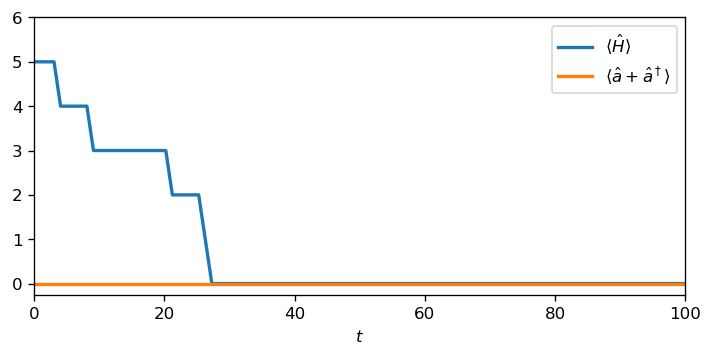

In [18]:
psi0 = fock(N, 5)

H = omega * a.dag() * a

c_ops = [np.sqrt(gamma) * a]

e_ops = [H, a + a.dag()]

tlist = np.linspace(0, 5 / gamma, 100)

# We perform only one quantum trajectory
sol = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj=1)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 6)

However, if by performing a large number of trajectories and averaging among them, we get the same results as the master equation case.

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.11s. Est. time left: 00:00:00:00
30.0%. Run time:   0.17s. Est. time left: 00:00:00:00
40.0%. Run time:   0.22s. Est. time left: 00:00:00:00


50.0%. Run time:   0.28s. Est. time left: 00:00:00:00
60.0%. Run time:   0.33s. Est. time left: 00:00:00:00
70.0%. Run time:   0.38s. Est. time left: 00:00:00:00
80.0%. Run time:   0.43s. Est. time left: 00:00:00:00
90.0%. Run time:   0.49s. Est. time left: 00:00:00:00
100.0%. Run time:   0.54s. Est. time left: 00:00:00:00
Total run time:   0.54s


(-0.2290000000000001, 6.0)

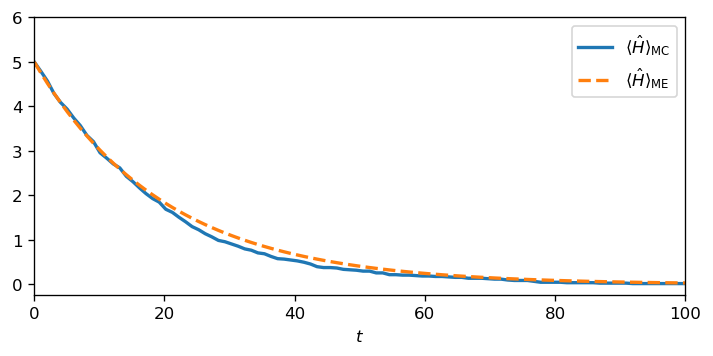

In [19]:
sol_mc = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj=100)
sol_me = mesolve(H, psi0, tlist, c_ops, e_ops)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol_mc.expect[0], label=r"$\langle \hat{H} \rangle_\mathrm{MC}$", lw=2)
ax.plot(tlist, sol_me.expect[0], label=r"$\langle \hat{H} \rangle_\mathrm{ME}$", ls="--", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
ax.set_ylim(None, 6)

## Here we take a look at the thermalization of the harmonic oscillator:
the bath is set at a temperature $T$ (given in units of $\hbar\omega/k_b$ and it can thus also provide energy to the system, rather than just absorbing it.
To include such a process we need to add a new jump operator, that can create an energy quantum in the harmonic oscillator (or a photon, in quantum optics language). Again, like in master equations, the dependence from the temperature enters in the coefficient of the loss/gain jump operators, for which losses enters with a factor $1+n_{\rm th}(T)$ while gain takes $n_{\rm th}(T)$. Notice that those are nothing else than the Einstein A,B coefficient for spontaneous/stimulated emission and absorption. This structure ensures the detailed balance in the steady state, that leads to correct thermalization when the system reaches the steady state.

10.0%. Run time:   0.41s. Est. time left: 00:00:00:03
20.0%. Run time:   0.94s. Est. time left: 00:00:00:03
30.0%. Run time:   1.34s. Est. time left: 00:00:00:03
40.0%. Run time:   1.88s. Est. time left: 00:00:00:02
50.0%. Run time:   2.26s. Est. time left: 00:00:00:02
60.0%. Run time:   2.72s. Est. time left: 00:00:00:01
70.0%. Run time:   3.10s. Est. time left: 00:00:00:01
80.0%. Run time:   3.64s. Est. time left: 00:00:00:00
90.0%. Run time:   4.15s. Est. time left: 00:00:00:00
100.0%. Run time:   4.64s. Est. time left: 00:00:00:00
Total run time:   4.67s
100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.07s


(0.0, 94.24777960769379)

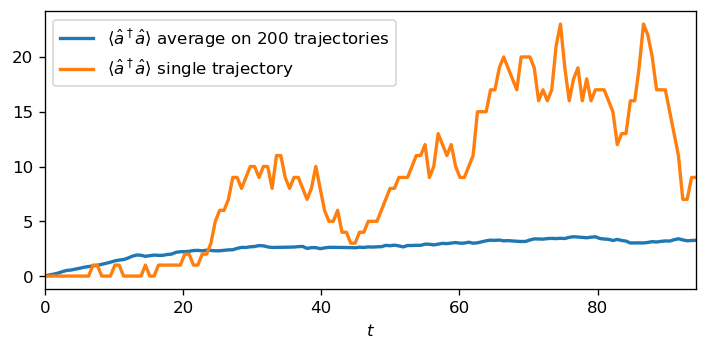

In [20]:
psi0 = fock(N, 0)

T = 4
NTh = 1./(np.exp(w/T)-1)
c_ops = [np.sqrt(gamma*(1+NTh)) * a, np.sqrt(gamma*(NTh)) * a.dag()]
e_ops = [H, a.dag()*a]

tlist = np.linspace(0, 15 * 2*np.pi, 150)
n_tot_traj = 200
sol_tot = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj=n_tot_traj)
sol_1 = mcsolve(H, psi0, tlist, c_ops, e_ops, ntraj=1)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol_tot.expect[1], label=r"$\langle \hat{a}^\dagger\hat{a} \rangle$ average on %d trajectories " % (n_tot_traj), lw=2)
ax.plot(tlist, sol_1.expect[1], label=r"$\langle \hat{a}^\dagger\hat{a} \rangle$ single trajectory", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
#ax.set_ylim(None, 6)

## Classwork project:

What happens to the driven-dissipative quantum harmonic oscillator in the presence of some Kerr non-linearity?
The Kerr non-linearity represents one of the most basics interaction terms, deriving from an effective repulsion (or attraction, dependetly from the sign) between photons. 
In the simple framework of a single photonic mode the description simplifies to a non-linear oscillator, where the non-linearity is a quartic term in the creation/annihilation operators.
The Kerr-oscillator Hamiltonian is then given by
$$
\hat{H} = \omega \hat{a}^\dagger \hat{a} + U \hat{a}^{\dagger 2} \hat{a}^2
$$

We can now repeat some of the above analysis in presence of a finite non-linearity $U\neq 0$.
The dynamics will be in general more complivcated with more prominent quantum effect, let's understand it!

Some questions to explore:
1) In the harmonic oscillator the coherent state is a 'special state' whose time evolution preserves the shape of the quantum wavepacket and the uncertanty remains minimized. In this sense it's the most classical state. Is it still true for the Kerr oscillator? (try to re-do the Schrodinger time evolution for a coherent initial state and make a movie of it)

2) Driven-dissipative Kerr oscillator! Nothing really special happens when we drive the harmonic oscillator, but what about the Kerr? Compute the power spectrum in the steady-state and the g2-correlation function, is there any trace of 'quantumness' there? Show them in a plot, respectively as a function of the driving frequency and as a function of the correlation time delay.

(You can google or chatgpting what is the power spectrum in quantum optics and how is implemented in QuTip; you will discover that is also related to correlation functions and in particular to the $g^{(1)}$, that also gives information on the so-called phase coherence).
(Notice that the concept of "quantumness" is given by comparing the system's behaviour to its eventual classical counterpart. Regarding $g^{(x)}$-correlations there are some simple theorems that says what a classical system can or cannot be. When such bound are violated you can say that you are witnessing a quantum feature!)



In [21]:
# System parameters
N = 30  # Number of Fock states
omc = 1.  # main frequency
gamma = 0.1  # Dissipation rate
F = 0.04  # Drive strength
omF = 1. #Drive frequency
U_kerr = 0.05 #Non-linearity
# Operators
a = destroy(N)

H = omc * a.dag() * a + U_kerr*a.dag()*a.dag()*a*a

In [23]:
alpha = 2 # Coherence of the initial state
# We start from a coherent state the most classic-like state
psi0 = coherent(N, alpha)
# List of the times for the time evolution
tlist = np.linspace(0, 2 * 2*np.pi/omc, 200)
sol = sesolve(H, psi0, tlist)


x = (a+a.dag())/(2.**.5)
E, T = x.eigenstates()
U = np.zeros((N, N)).astype(np.complex128)
for i in range(N):
    U[:,i] = T[i].full().flatten()
U = Qobj(U)
xlist = ( U.dag() * x * U ).diag()
dx = xlist[1] - xlist[0]


fig, ax = plt.subplots(dpi=120, figsize=(7, 3))
psi0_x = U.dag() * sol.states[0]
line, = ax.plot(xlist, 700 * np.abs(psi0_x.full())**2, lw=2)
V = omc * xlist**2. + U_kerr*xlist**4.
ax.plot(xlist, V, color="black", ls="--")
ax.set_xlabel(r"$x$")
ax.set_xlim(xlist[0], xlist[-1])
ax.set_ylim(0, 420)
#plt.show
plt.close(fig) # Otherwise the static figure also appears

def update(frame):
    psi_t = U.dag() * sol.states[frame]
    line.set_ydata( 700 * np.abs(psi_t.full())**2 )
    return line,

fps = 25
ani = FuncAnimation(fig, update, frames=len(tlist), blit=True, interval=1000 / fps)

HTML(ani.to_html5_video())
# HTML(ani.to_jshtml())

In [24]:
Hdriven = H - omF * a.dag() * a + F*(a+a.dag()) # Driven Hamiltonian of the Kerr oscillator in the rotating frame
c_ops = [np.sqrt(gamma)*a] #given jump operators (in this case only 'a')
rho_ss = steadystate(Hdriven, c_ops) #Steady state of the master equation for a given H 

taus = np.linspace(0., 40., 200)
G2 = correlation_3op_1t(Hdriven, rho_ss, taus, c_ops, a.dag(), a.dag()*a, a)
avgNph = expect(a.dag()*a, rho_ss)
g2 = G2/(avgNph**2.)

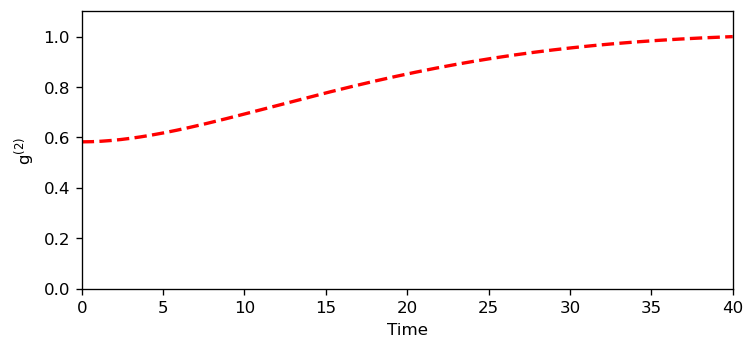

In [25]:
# plot the spectrum
fig, ax = plt.subplots(dpi=120, figsize=(7, 3))
ax.plot(taus, np.abs(g2), 'r--', lw=2)
ax.set_xlabel('Time')
ax.set_ylabel('g$^{(2)}$')
plt.axis( [0, 40, 0, 1.1] )
plt.show()

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   0.04s


(0.0, 125.66370614359172)

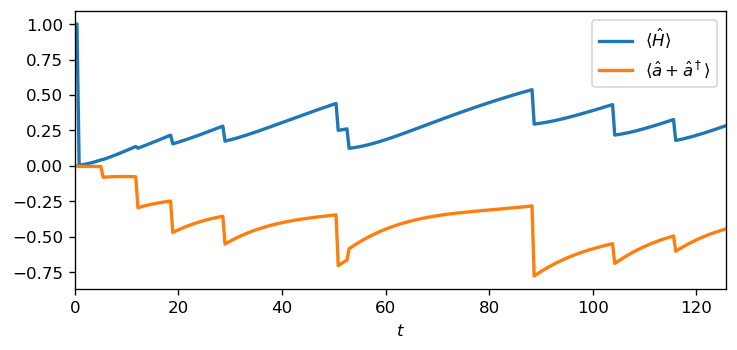

In [26]:
psi0 = fock(N, 1)

c_ops = [np.sqrt(gamma) * a]
e_ops = [H, a + a.dag()]

tlist = np.linspace(0, 20 * 2*np.pi, 300)

# We perform only one quantum trajectory
sol = mcsolve(Hdriven, psi0, tlist, c_ops, e_ops, ntraj=1)

fig, ax = plt.subplots(dpi=120, figsize=(7, 3))

ax.plot(tlist, sol.expect[0], label=r"$\langle \hat{H} \rangle$", lw=2)
ax.plot(tlist, sol.expect[1], label=r"$\langle \hat{a} + \hat{a}^\dagger \rangle$", lw=2)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_xlim(tlist[0], tlist[-1])
#ax.set_ylim(None, 6)